In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)
from pandas import json_normalize
import numpy as np
import os
import csv
import multiprocessing as mp
import re
from datetime import datetime
# import helper as h
# import AQDataHelper as aqh
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib
import geopy


import warnings
warnings.filterwarnings("ignore")


In [3]:
df_articles = pd.read_csv("../dataset/News_articles_dataset/News_articles_dataset.csv.gz")
df_articles

,media,date,url,heading,content,other.author,other.top_image,other.category,city,year,state,district,matches
0,TOI,2010-01-01,http://timesofindia.indiatimes.com//city/mumbai/Mumbai-celebrates-a-cool-New-Years-Eve-at-13-4C/...,Mumbai celebrates a cool New Year's Eve at 13.4फ्C,MUMBAI: The city witnessed its lowest temperature of the season on New Year ’s Eve when the merc...,"TNN / Jan 1, 2010, 01:47 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,mumbai,2010.0,maharashtra,mumbai suburban,{'smog': 3.0}
1,TOI,2010-01-02,http://timesofindia.indiatimes.com//city/lucknow/Dense-fog-leads-to-tripping-of-power-lines/arti...,Dense fog leads to tripping of power lines,LUCKNOW: The UP Power Corporation Limited is keeping its fingers crossed for Saturday with the s...,"TNN / Jan 2, 2010, 06:40 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,lucknow,2010.0,uttar pradesh,lucknow,{'air pollutants': 2.0}
2,TOI,2010-01-09,http://timesofindia.indiatimes.com//city/chennai/City-has-high-levels-of-smog-forming-ozone/arti...,City has high levels of smog-forming ozone,CHENNAI: Dangerous levels of ground-level ozone that causes respiratory ailments could be envelo...,"Bhama Devi Ravi / TNN / Jan 9, 2010, 00:37 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,chennai,2010.0,tamil nadu,chennai,"{'ozone': 9.0, 'smog': 4.0}"
3,TOI,2010-01-11,http://timesofindia.indiatimes.com//city/jaipur/Woman-four-kids-in-hospital-after-inhaling-smoke...,"Woman, four kids in hospital after inhaling smoke",JAIPUR: A woman and her four kids were admitted to a city hospital in a serious condition after ...,"TNN / Jan 11, 2010, 01:56 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,jaipur,2010.0,rajasthan,jaipur,{'carbon monoxide': 1.0}
4,TOI,2010-01-13,http://timesofindia.indiatimes.com//city/chennai/Pollution-high-on-Bhogi-eve-Study/articleshow/5...,Pollution high on Bhogi eve: Study,"CHENNAI: By the time you get to read this, the Bhogi pollutants may have enveloped the city, but...","Bhama Devi Ravi / TNN / Jan 13, 2010, 04:23 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,chennai,2010.0,tamil nadu,chennai,"{'air quality': 1.0, 'carbon monoxide': 1.0, 'ozone': 1.0, 'so2': 1.0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17369,Hindu,2021-05-16,https://www.thehindu.com/news/national/andhra-pradesh/naval-dockyard-teams-repair-two-oxygen-pla...,Naval Dockyard teams repair two oxygen plants in Nellore and Srikalahasti,Oxygen supply gets a big boost with this in the State during the pandemic\n\nTeams from the Nava...,SpecialCorrespondent,https://www.thehindu.com/news/national/andhra-pradesh/fvjzld/article34572702.ece/ALTERNATES/LAND...,andhra pradesh,visakhapatnam,NaN,andhra pradesh,visakhapatnam,{'carbon monoxide': 2.0}
17370,Hindu,2021-05-24,https://www.thehindu.com/news/national/kerala/greens-call-for-a-relook-into-silverline-implement...,Greens call for a relook into SilverLine implementation,"The Kerala Paristhithi Aikya Vedi, a forum of environmentalists, has urged Chief Minister Pinara...",SpecialCorrespondent,https://www.thehindu.com/static/theme/default/base/img/og-image.jpg,kerala,thiruvananthapuram,NaN,kerala,thiruvananthapuram,{'air pollution': 1.0}
17371,Hindu,2021-05-25,https://www.thehindu.com/news/national/karnataka/cftris-ozone-based-air-disinfection-system-to-c...,CFTRI’s ozone-based air disinfection system to combat droplet infections,The CSIR-Central Food Technological Research Institute (CFTRI) in Mysuru has come up with an ozo...,LaiqhAKhan,https://www.thehindu.com/sci-tech/science/wsmdd0/article33283019.ece/ALTERNATES/LANDSCAPE_615/CF...,karnataka,mysuru,NaN,karnataka,mysuru,{'ozone': 9.0}
17372,Hindu,2021-05-28,https://www.thehindu

In [4]:
#load PM2.5 data 2010-2019 (cpcb)
root_path = "../PMdataset/"
df_daily_city_stn = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_station_2010_19.csv",index_col=0)
df_daily_city = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_2010_19.csv",index_col=0)
#df_daily_city = df_daily_city.groupby(["From Date","city"]).mean().reset_index()
df_daily_city

,Unnamed: 0,From Date,city,WS,WD,Gust,Variance,AT,RH,SR,BP,PPAccum,Power,PM10,PM2_5,NO,NO2,NOx,CO,CO2,Ozone,BlackCarbon,Benzene,Toluene,Eth-Benzene,Xylene,CH4,NMHC,VWS,THC,NH3,SO2,Temp,MP-Xylene,RF,RackTemp,P_Xylene,O Xylene,ETH,SPM,AP,MH,readings_in_day,total_stations,active_stations,state
0,0,2010-01-01,Agra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Uttar Pradesh
1,1,2010-01-01,Ahmedabad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Gujarat
2,2,2010-01-01,Ambala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Haryana
3,3,2010-01-01,Ankleshwar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Gujarat
4,4,2010-01-01,Bahadurgarh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Haryana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202192,202192,2019-04-30,Udaipur,1.017579,253.649263,NaN,NaN,NaN,17.871263,192.898000,757.183158,NaN,NaN,87.814737,34.304255,13.917158,19.854526,33.771684,0.734835,NaN,38.070213,NaN,1.563936,NaN,4.092842,NaN,NaN,NaN,NaN,NaN,12.120947,12.064725,33.071053,1.188842,0.0,NaN,NaN,3.700211,NaN,NaN,NaN,NaN,94.0,1,1,Rajasthan
202193,202193,2019-04-30,Ujjain,4.636842,255.042105,NaN,NaN,36.660000,18.252632,161.242105,NaN,NaN,NaN,147.452632,40.126316,NaN,8.891011,5.250562,0.819535,NaN,78.206522,NaN,0.000000,0.620000,0.000000,NaN,NaN,NaN,NaN,NaN,19.031461,8.647059,31.801075,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,1,1,Madhya Pradesh
202194,202194,2019-04-30,Varanasi,0.801053,180.757895,NaN,NaN,33.582105,23.600000,80.157895,745.378947,NaN,NaN,331.126761,131.732394,51.202360,104.323370,74.652174,0.860652,NaN,76.047692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.522105,NaN,NaN,37.748652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0,1,1,Uttar Pradesh
202195,202195,2019-04-30,Vijayawada,0.519041,221.018904,NaN,NaN,37.019178,55.307671,228.706154,749.476301,NaN,NaN,50.119577,20.220000,6.365139,14.738356,21.004658,NaN,NaN,NaN,NaN,0.996849,1.870137,0.057397,NaN,NaN,NaN,5.000000,NaN,5.329589,6.234658,NaN,0.734110,0.0,NaN,NaN,1.899589,NaN,NaN,NaN,NaN,67.0,1,1,Andhra Pradesh


In [9]:
df_ip = df_daily_city
city_state_dict = dict(zip(df_ip["city"].values,df_ip["state"].values))
len(city_state_dict), city_state_dict

(101,
 {'Agra': 'Uttar Pradesh',
  'Ahmedabad': 'Gujarat',
  'Ambala ': 'Haryana',
  'Ankleshwar': 'Gujarat',
  'Bahadurgarh ': 'Haryana',
  'Ballabgarh': 'Haryana',
  'Bengaluru': 'Karnataka',
  'Bhiwani': 'Haryana',
  'Chennai': 'Tamil Nadu',
  'Damoh': 'Madhya Pradesh',
  'Delhi': 'Delhi',
  'Dharuhera': 'Haryana',
  'Faridabad': 'Haryana',
  'Fatehabad ': 'Haryana',
  'Gandhinagar': 'Gujarat',
  'Ghaziabad': 'Uttar Pradesh',
  'Gurugram': 'Haryana',
  'Guwahati': 'Assam',
  'Hapur': 'Uttar Pradesh',
  'Hisar': 'Haryana',
  'Hyderabad': 'Telangana',
  'Jind': 'Haryana',
  'Kaithal': 'Haryana',
  'Kanpur': 'Uttar Pradesh',
  'Karnal': 'Haryana',
  'Kurukshetra ': 'Haryana',
  'Loni Dehat': 'Uttar Pradesh',
  'Lucknow': 'Uttar Pradesh',
  'Maihar': 'Madhya Pradesh',
  'Mandikhera': 'Haryana',
  'Manesar ': 'Haryana',
  'Mumbai': 'Maharashtra',
  'Nagpur': 'Maharashtra',
  'Narnaul': 'Haryana',
  'Navi Mumbai': 'Maharashtra',
  'Palwal ': 'Haryana',
  'Panipat': 'Haryana',
  'Pune': 'M

In [6]:
#load OpenAQ data 2019-2021
root_path = "../PMdataset/"
df_daily_city_stn_oq = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_station_2019_21_openaq.csv",index_col=0)
df_daily_city_oq = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_2019_21_openaq.csv",index_col=0)
#df_daily_city_oq = df_daily_city_oq.groupby(["From Date","city"]).mean().reset_index()
df_daily_city_oq

,From Date,city,PM2_5,readings,total_stations,active_stations
0,2019-01-18,Delhi,133.960000,2.0,1,1
2,2019-04-30,Agra,90.000000,1.0,1,1
3,2019-04-30,Ajmer,105.640000,2.0,1,1
4,2019-04-30,Amaravati,22.000000,1.0,1,1
6,2019-04-30,Amritsar,50.970000,1.0,1,1
...,...,...,...,...,...,...
75127,2021-08-01,Solapur,18.020000,69.0,1,1
75128,2021-12-03,Solapur,NaN,0.0,1,0
75129,2021-12-04,Solapur,NaN,0.0,1,0
75130,2021-12-05,Solapur,14.172069,29.0,1,1


In [7]:
#merge cpcb and openaq 
df_daily_city_merged = pd.concat([df_daily_city,df_daily_city_oq])[["From Date","city",
                                                                    "PM2_5","total_stations","active_stations","state"]]

df_daily_city_merged.city = df_daily_city_merged.city.apply(lambda x:x.strip().lower())
df_daily_city_merged["From Date"] = pd.to_datetime(df_daily_city_merged["From Date"])
df_daily_city_merged = df_daily_city_merged.groupby(["From Date","city"]).mean().reset_index()
df_daily_city_merged

,From Date,city,PM2_5,total_stations,active_stations
0,2010-01-01,agra,NaN,1.0,0.0
1,2010-01-01,ahmedabad,NaN,1.0,0.0
2,2010-01-01,ambala,NaN,1.0,0.0
3,2010-01-01,ankleshwar,NaN,1.0,0.0
4,2010-01-01,bahadurgarh,NaN,1.0,0.0
...,...,...,...,...,...
254058,2021-08-01,solapur,18.020000,1.0,1.0
254059,2021-12-03,solapur,NaN,1.0,0.0
254060,2021-12-04,solapur,NaN,1.0,0.0
254061,2021-12-05,solapur,14.172069,1.0,1.0


In [10]:
df_daily_city_merged["state"] = df_daily_city_merged["city"].apply(lambda x:city_state_dict[x.capitalize()].lower() if x.capitalize() in city_state_dict else np.nan)
df_daily_city_merged

,From Date,city,PM2_5,total_stations,active_stations,state
0,2010-01-01,agra,NaN,1.0,0.0,uttar pradesh
1,2010-01-01,ahmedabad,NaN,1.0,0.0,gujarat
2,2010-01-01,ambala,NaN,1.0,0.0,NaN
3,2010-01-01,ankleshwar,NaN,1.0,0.0,gujarat
4,2010-01-01,bahadurgarh,NaN,1.0,0.0,NaN
...,...,...,...,...,...,...
254058,2021-08-01,solapur,18.020000,1.0,1.0,maharashtra
254059,2021-12-03,solapur,NaN,1.0,0.0,maharashtra
254060,2021-12-04,solapur,NaN,1.0,0.0,maharashtra
254061,2021-12-05,solapur,14.172069,1.0,1.0,maharashtra


In [11]:
df_daily_city_merged.state.unique()

array(['uttar pradesh', 'gujarat', nan, 'haryana', 'karnataka',
       'tamil nadu', 'madhya pradesh', 'delhi', 'assam', 'telangana',
       'maharashtra', 'bihar', 'west bengal', 'rajasthan',
       'andhra pradesh', 'punjab', 'odisha', 'jharkhand', 'kerala'],
      dtype=object)

In [13]:
#check city wise data start date & end date
def get_start_date(city,threshold = 0.8,n = 365):
    print(city)
    test = df_daily_city_merged[df_daily_city_merged.city == city]
    test["From Date"] = pd.to_datetime(test["From Date"])
    test_drop_na = test.dropna(subset=["PM2_5"])

    for idx,row in test_drop_na.iterrows():
        curr_date = row["From Date"]
        n = 365
        end_date = curr_date+pd.Timedelta(days=n)
        date_range = pd.date_range(curr_date,end_date)
        temp = test[test["From Date"].isin(date_range)]
        frac = len(temp.dropna(subset=["PM2_5"]))/len(temp)
        #print(frac)
        threshold = 0.8
        if frac >threshold:
            print(curr_date)
            return curr_date
def get_unique_cities_from_df(df,col="city"):
    '''
    returns dataframe of city->articles from dataframe
    as city can be list so unique() will not work
    '''
    unq = {}
    for each in df[col].values:
        if type(each) == str:
            cities = [each]
        elif type(each) == list:
            cities = each
        else:
            continue
        for city in cities:
            try:
                unq[city]+=1
            except:
                unq[city] = 1
    df = pd.DataFrame(unq.items(),columns = ["city","articles"]).sort_values("articles",ascending=False)
    return df

In [29]:
cdf = get_unique_cities_from_df(df_articles)
igp_cities = ["delhi","agra","lucknow","patna","kanpur","varanasi","noida","gurugram","faridabad","kolkata","amritsar"]
most_discussed_cities = []
#most_discussed_cities = list(cdf.nlargest(11,"articles")["city"].values) #most 11 discussed cities in news-media
needed_cities = list(set(igp_cities + most_discussed_cities)) #most
print(len(needed_cities),needed_cities)


#needed_cities = h.get_unique_cities_from_df(df_articles).nlargest(15,"articles")["city"].values

start_date = datetime(2018,4,1)
end_date = datetime(2021,4,1)

#df_cross_cities = df_daily_city_merged[(df_daily_city_merged["From Date"] >= start_date) & (df_daily_city_merged["From Date"] <= end_date)]
df_cross_cities = df_daily_city_merged.copy()
df_cross_cities = df_cross_cities[df_cross_cities.city.isin(needed_cities)]
dfs = []
for city in needed_cities:
    try:
        start_date = get_start_date(city)
        df = df_cross_cities[(df_cross_cities["city"] == city) & (df_cross_cities["From Date"]>start_date)]
        dfs.append(df)
    except Exception as e:
        print(city,e)
    
df_cross_cities = pd.concat(dfs)
df_cross_cities = pd.crosstab(index=df_cross_cities["From Date"],
                              columns=df_cross_cities.city,values=df_cross_cities["PM2_5"],aggfunc=lambda x:x)
df_cross_cities

11 ['amritsar', 'patna', 'delhi', 'lucknow', 'varanasi', 'gurugram', 'noida', 'kolkata', 'agra', 'kanpur', 'faridabad']
amritsar
2017-02-27 00:00:00
patna
2015-10-01 00:00:00
delhi
2010-02-17 00:00:00
lucknow
2015-03-18 00:00:00
varanasi
2014-09-13 00:00:00
gurugram
2016-01-22 00:00:00
noida
2017-07-17 00:00:00
kolkata
2018-04-10 00:00:00
agra
2015-05-11 00:00:00
kanpur
2015-05-12 00:00:00
faridabad
2015-05-20 00:00:00


city,agra,amritsar,delhi,faridabad,gurugram,kanpur,kolkata,lucknow,noida,patna,varanasi
From Date,,,,,,,,,,,
2010-02-18,NaN,NaN,135.687500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-19,NaN,NaN,107.047158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-20,NaN,NaN,15.914687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-21,NaN,NaN,9.360000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-22,NaN,NaN,17.640370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-17,NaN,NaN,34.246377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-18,23.200000,NaN,16.128846,40.66,NaN,4.7,19.250000,8.18,NaN,NaN,NaN
2021-06-19,10.000000,53.615,30.945804,31.00,39.6,25.0,29.350000,21.96,18.355000,NaN,20.00


In [35]:
(df_cross_cities.isna()).sum(axis=0)

city
agra           2081
amritsar       2783
delhi             3
faridabad      2037
gurugram       2326
kanpur         2060
kolkata        3001
lucknow        1940
noida          2815
patna          2279
varanasi       1913
day_of_year       0
dtype: int64

In [36]:
#filter based in start & end date
df_cross_cities= df_cross_cities[df_cross_cities.index.isin(pd.date_range(start="2018-04-01",end="2021-04-01"))]
df_cross_cities

city,agra,amritsar,delhi,faridabad,gurugram,kanpur,kolkata,lucknow,noida,patna,varanasi,day_of_year
From Date,,,,,,,,,,,,
2018-04-01,61.916667,43.980000,74.347176,77.404255,98.030937,53.987342,NaN,74.332864,63.175156,73.619565,62.931034,04-01
2018-04-02,71.232558,34.550000,96.461212,95.125000,64.897879,74.204301,NaN,100.093734,164.000000,63.729167,75.811111,04-02
2018-04-03,88.224719,65.538750,100.474653,109.041667,90.604022,60.200000,NaN,162.669110,70.564479,97.565217,84.022222,04-03
2018-04-04,79.239130,58.903846,118.512089,122.125000,101.449886,76.568421,NaN,164.142913,NaN,86.623656,85.168539,04-04
2018-04-05,82.232558,50.727021,144.107495,154.958333,118.452604,51.106383,NaN,82.921629,124.883177,64.576087,47.957447,04-05
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-28,374.000000,NaN,126.025294,215.116667,114.500000,161.150000,61.071382,90.000000,195.666667,136.792000,NaN,03-28
2021-03-29,58.000000,NaN,103.573150,175.566667,59.550000,NaN,55.847151,102.000000,54.000000,100.674000,NaN,03-29
2021-03-30,NaN,NaN,95.200427,159.790000,78.996667,54.600000,48.878437,72.000000,49.000000,76.684000,NaN,03-30


In [37]:
df_cross_cities.index.min()

Timestamp('2018-04-01 00:00:00')

### Heatmap like plot for Figure_4

In [38]:
df_cross_cities["day_of_year"] = df_cross_cities.apply(lambda x: x.name.date().strftime("%m-%d") ,axis=1)
df_cross_cities

city,agra,amritsar,delhi,faridabad,gurugram,kanpur,kolkata,lucknow,noida,patna,varanasi,day_of_year
From Date,,,,,,,,,,,,
2018-04-01,61.916667,43.980000,74.347176,77.404255,98.030937,53.987342,NaN,74.332864,63.175156,73.619565,62.931034,04-01
2018-04-02,71.232558,34.550000,96.461212,95.125000,64.897879,74.204301,NaN,100.093734,164.000000,63.729167,75.811111,04-02
2018-04-03,88.224719,65.538750,100.474653,109.041667,90.604022,60.200000,NaN,162.669110,70.564479,97.565217,84.022222,04-03
2018-04-04,79.239130,58.903846,118.512089,122.125000,101.449886,76.568421,NaN,164.142913,NaN,86.623656,85.168539,04-04
2018-04-05,82.232558,50.727021,144.107495,154.958333,118.452604,51.106383,NaN,82.921629,124.883177,64.576087,47.957447,04-05
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-28,374.000000,NaN,126.025294,215.116667,114.500000,161.150000,61.071382,90.000000,195.666667,136.792000,NaN,03-28
2021-03-29,58.000000,NaN,103.573150,175.566667,59.550000,NaN,55.847151,102.000000,54.000000,100.674000,NaN,03-29
2021-03-30,NaN,NaN,95.200427,159.790000,78.996667,54.600000,48.878437,72.000000,49.000000,76.684000,NaN,03-30


In [39]:
#df_cross_cities.groupby("day_of_year").aggregate(lambda x: sum(x.dropna())/len(x.dropna()) if len(x.dropna()) else np.nan)
df_cross_cities_yday_avg = df_cross_cities.groupby("day_of_year").mean()
df_cross_cities_yday_avg

city,agra,amritsar,delhi,faridabad,gurugram,kanpur,kolkata,lucknow,noida,patna,varanasi
day_of_year,,,,,,,,,,,
01-01,266.698864,83.531003,339.500161,308.607128,296.732793,287.404168,158.835409,268.894621,352.894609,266.542610,290.180489
01-02,217.708791,67.501699,286.541694,272.483981,284.044378,281.060555,158.556038,276.175727,311.942907,293.614419,251.950222
01-03,181.764706,56.305769,213.416915,184.997108,170.000772,189.386701,144.005913,197.238824,214.131900,277.188675,191.683816
01-04,135.981481,48.950430,177.967932,180.672158,121.098769,219.847844,150.226441,179.901643,184.805661,239.647225,134.890120
01-05,168.283809,33.799005,163.549142,145.166978,132.729565,230.228400,159.456713,203.904844,162.422537,230.358128,159.540609
...,...,...,...,...,...,...,...,...,...,...,...
12-27,163.674157,62.652531,248.279012,263.867595,148.220943,292.720153,215.919662,182.642965,266.438827,230.902937,176.031373
12-28,133.322387,67.809740,212.078000,220.034782,156.472487,224.959311,184.463257,190.058697,224.455215,204.349044,172.563389
12-29,130.258070,82.956465,239.274173,231.359545,198.970062,235.908719,190.776002,175.776517,249.059945,194.340802,188.031313


In [40]:
#check if some entries has null values
df_cross_cities_yday_avg.isna().sum(axis=0)

city
agra         0
amritsar     0
delhi        0
faridabad    0
gurugram     0
kanpur       0
kolkata      0
lucknow      0
noida        0
patna        0
varanasi     0
dtype: int64

In [41]:
violation_df = (df_cross_cities_yday_avg>60).astype(int)
np.array(violation_df["amritsar"])

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,

In [42]:
violation_df.sum(axis=0)/365

city
agra         0.578082
amritsar     0.252055
delhi        0.660274
faridabad    0.668493
gurugram     0.745205
kanpur       0.526027
kolkata      0.400000
lucknow      0.750685
noida        0.657534
patna        0.616438
varanasi     0.646575
dtype: float64

In [43]:
sorted_city = ["delhi","gurugram","patna","varanasi","faridabad","noida","lucknow","kanpur","agra","kolkata","amritsar"]
sorted_city_cap = [city.capitalize() for city in sorted_city]
sorted_city

['delhi',
 'gurugram',
 'patna',
 'varanasi',
 'faridabad',
 'noida',
 'lucknow',
 'kanpur',
 'agra',
 'kolkata',
 'amritsar']

In [44]:
def format_axes(ax,twinx=False,SPINE_COLOR = "gray"):
    
    if twinx:
        for spine in ['top']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom', 'right']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)
        
    else:
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)

    return ax

def latexify(fig_width=None, fig_height=None, columns=2):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.32 if columns==1 else 6.75 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)

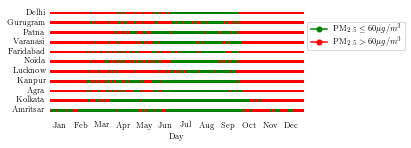

In [45]:
from matplotlib.lines import Line2D
import calendar as cal
fig,ax = plt.subplots()
latexify(columns=2, fig_width=5,fig_height=2)

days = len(violation_df)
ncities = 11
y_cord = np.linspace(0,1,num = ncities)
x_cord = np.linspace(0,1,num = days)
color = ["green","red"]
month_names = [each[:3].capitalize() for each in list(cal.month_name)[1:]] + [""]

ax.set_facecolor('white')
ax.set_xticks(np.linspace(0,1,13) + (1/26))
ax.set_xticklabels(month_names)
ax.set_yticks(np.linspace(0,1,ncities))
ax.set_yticklabels(sorted_city_cap[::-1])

for ind in range(ncities):
    test = np.array(violation_df[sorted_city[len(sorted_city)-ind-1]])
    color_arr = [color[each] for each in test]
    ax.scatter(x=x_cord,y=np.array([y_cord[ind]]*days),marker="s",c=color_arr,label="k",s=3)

    
plt.tick_params(
    labelsize = 8,
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True, # labels along the bottom edge are off
    left=False
)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='y', which='major', pad=-12) 
ax.set_xlabel("Day")

legend_elements = [Line2D([0], [0], marker='o', color='g', label='PM$_{2.5}$ $\leq 60 \mu g/m^3$',
                          markerfacecolor='green', markersize=5),
                  Line2D([0], [0], marker='o', color='r', label='PM$_{2.5}$ $> 60 \mu g/m^3$',
                          markerfacecolor='r', markersize=5)]

ax.legend(handles=legend_elements, bbox_to_anchor=(0.955,0.9))

#plt.title("Violation of Indian limit(60 ug/m^3) in APR-2018 to APR-2021");
#h.format_axes(ax)

In [ ]:
fig.savefig("../figures/fig4_pm25_viloation_igp.pdf",bbox_inches="tight")